#İnstall Detectron and Mask2Former

In [ ]:
# Install detectron2
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

In [ ]:
!git clone https://github.com/facebookresearch/detectron2.git

In [ ]:
!cd detectron2/
!python -m pip install -e detectron2

In [ ]:
# clone and install Mask2Former
!git clone https://github.com/facebookresearch/Mask2Former.git
%cd Mask2Former
!pip install -U opencv-python
!pip install git+https://github.com/cocodataset/panopticapi.git
!pip install -r requirements.txt
%cd mask2former/modeling/pixel_decoder/ops
!python setup.py build install
%cd ../../../../

In [1]:
#!!!!!!!!!!!!!!!!!!!!!!!!!Firstly restart kernel
# You may need to restart your runtime prior to this, to let your installation take effect
%cd /content/Mask2Former
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
setup_logger(name="mask2former")

# import some common libraries
import numpy as np
import cv2
import torch
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.projects.deeplab import add_deeplab_config
#coco_metadata = MetadataCatalog.get("coco_2017_val_panoptic")

# import Mask2Former project
from mask2former.config import add_maskformer2_config

/content/Mask2Former


#Preparing Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd ../
!unzip /content/drive/MyDrive/fruit_segmentation/fruit_dataset.zip > /dev/null
%cd /content/Mask2Former

In [3]:
def get_dicts(img_dir,classes):
    """This function loads the JSON file created with the annotator and converts it to
    the detectron2 metadata specifications.
    """
    # load the JSON file
    json_file = os.path.join(img_dir, "via_project_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    # loop through the entries in the JSON file
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        # add file_name, image_id, height and width information to the records
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = v["regions"]
        print(annos)

        objs = []
        # one image can have multiple annotations, therefore this loop is needed
        for annotation in annos:
            # reformat the polygon information to fit the specifications
            anno = annotation["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            region_attributes = annotation["region_attributes"]["type"]

            # specify the category_id to match with the class.
        
            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(region_attributes),
                "iscrowd": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

In [4]:
from detectron2.data import MetadataCatalog, DatasetCatalog

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
from datetime import datetime
import pickle
from pathlib import Path
from tqdm import tqdm

from detectron2.structures import BoxMode

In [5]:
classes = ['apple', 'grape','lemon','orange','strawberry']

for d in ["train", "val"]:
    DatasetCatalog.register(
        "metadata_" + d,
        lambda d=d: get_dicts(("/content/fruit_dataset/" + d),classes),
    )

train_metadata = MetadataCatalog.get("metadata_train")
val_metadata = MetadataCatalog.get("metadata_val")

dataset_dicts = get_dicts(("/content/fruit_dataset/train"),classes)

[{'shape_attributes': {'name': 'polygon', 'all_points_x': [146, 130, 146, 165, 207, 246, 276, 283, 273, 243, 205, 164], 'all_points_y': [129, 83, 35, 25, 9, 21, 53, 89, 135, 155, 171, 153]}, 'region_attributes': {'name': 'not_defined', 'type': 'apple', 'image_quality': {'good': True, 'frontal': True, 'good_illumination': True}}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [196, 227, 258, 283, 296, 327, 338, 346, 339, 307, 272, 242, 222, 195, 192], 'all_points_y': [220, 177, 162, 166, 187, 206, 209, 248, 283, 301, 319, 288, 271, 274, 241]}, 'region_attributes': {'name': 'not_defined', 'type': 'apple', 'image_quality': {'good': True, 'frontal': True, 'good_illumination': True}}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [341, 365, 380, 400, 398, 367, 345, 317, 342, 347], 'all_points_y': [209, 187, 205, 236, 273, 309, 318, 313, 277, 245]}, 'region_attributes': {'name': 'not_defined', 'type': 'apple', 'image_quality': {'good': True, 'frontal': True, 'good_illu

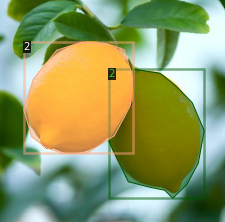

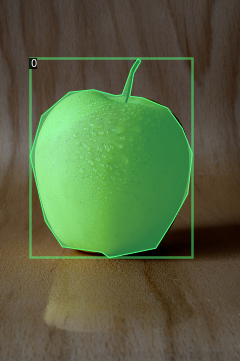

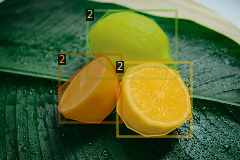

In [8]:
import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

#Training

In [33]:
cfg = get_cfg()
add_deeplab_config(cfg)
add_maskformer2_config(cfg)
cfg.merge_from_file("/content/Mask2Former/configs/coco/instance-segmentation/swin/maskformer2_swin_small_bs16_50ep.yaml")
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/maskformer/mask2former/coco/instance/swin/maskformer2_swin_small_bs16_50ep/swin_small_patch4_window7_224.pkl'
#cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/mask2former/output2/model_final.pth"
cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON = False
cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON = True
cfg.MODEL.MASK_FORMER.TEST.PANOPTIC_ON = False
cfg.DATASETS.TRAIN = ("metadata_train",)
cfg.DATASETS.TEST = ("metadata_val",)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 5
cfg.SOLVER.IMS_PER_BATCH = 1

cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.BASE_LR = 0.001

In [34]:
import os
from train_net import Trainer

In [35]:
resume_dir = os.getcwd()+'/output/'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)

#trainer.resume_or_load(resume_dir)
#trainer.resume_or_load(resume=False)

[12/28 14:16:18 d2.engine.defaults]: Model:
MaskFormer(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): L

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [36]:
trainer.train()

[12/28 14:16:23 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


[12/28 14:16:39 d2.utils.events]:  eta: 0:13:19  iter: 19  total_loss: 93.8  loss_ce: 1.759  loss_mask: 3.57  loss_dice: 4.188  loss_ce_0: 3.687  loss_mask_0: 2.473  loss_dice_0: 3.303  loss_ce_1: 1.534  loss_mask_1: 3.111  loss_dice_1: 3.383  loss_ce_2: 1.982  loss_mask_2: 3.335  loss_dice_2: 3.452  loss_ce_3: 2.04  loss_mask_3: 3.253  loss_dice_3: 3.558  loss_ce_4: 1.85  loss_mask_4: 3.407  loss_dice_4: 3.789  loss_ce_5: 1.878  loss_mask_5: 3.317  loss_dice_5: 3.737  loss_ce_6: 1.84  loss_mask_6: 3.555  loss_dice_6: 3.813  loss_ce_7: 1.93  loss_mask_7: 3.526  loss_dice_7: 3.812  loss_ce_8: 1.924  loss_mask_8: 3.803  loss_dice_8: 3.986  time: 0.7999  data_time: 0.0343  lr: 0.0001  max_mem: 11628M
[12/28 14:16:56 d2.utils.events]:  eta: 0:13:09  iter: 39  total_loss: 91.6  loss_ce: 1.464  loss_mask: 3.779  loss_dice: 3.682  loss_ce_0: 3.357  loss_mask_0: 2.978  loss_dice_0: 2.864  loss_ce_1: 1.378  loss_mask_1: 3.458  loss_dice_1: 3.498  loss_ce_2: 1.409  loss_mask_2: 3.703  loss_dice_

/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


[12/28 14:17:12 d2.utils.events]:  eta: 0:12:44  iter: 59  total_loss: 76.9  loss_ce: 1.242  loss_mask: 2.942  loss_dice: 3.537  loss_ce_0: 3.06  loss_mask_0: 2.213  loss_dice_0: 2.909  loss_ce_1: 0.9553  loss_mask_1: 3.099  loss_dice_1: 3.095  loss_ce_2: 1.215  loss_mask_2: 3.157  loss_dice_2: 3.538  loss_ce_3: 1.194  loss_mask_3: 2.994  loss_dice_3: 3.633  loss_ce_4: 1.144  loss_mask_4: 2.792  loss_dice_4: 3.7  loss_ce_5: 1.146  loss_mask_5: 2.915  loss_dice_5: 3.646  loss_ce_6: 1.16  loss_mask_6: 3.019  loss_dice_6: 3.499  loss_ce_7: 1.175  loss_mask_7: 3.013  loss_dice_7: 3.592  loss_ce_8: 1.191  loss_mask_8: 3.169  loss_dice_8: 3.516  time: 0.8065  data_time: 0.0054  lr: 0.0001  max_mem: 11678M
[12/28 14:17:28 d2.utils.events]:  eta: 0:12:16  iter: 79  total_loss: 74.87  loss_ce: 1.22  loss_mask: 2.916  loss_dice: 2.929  loss_ce_0: 2.775  loss_mask_0: 2.639  loss_dice_0: 2.224  loss_ce_1: 1.271  loss_mask_1: 2.836  loss_dice_1: 2.737  loss_ce_2: 1.216  loss_mask_2: 2.765  loss_dic

/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


[12/28 14:18:16 d2.utils.events]:  eta: 0:11:24  iter: 139  total_loss: 75.12  loss_ce: 1.282  loss_mask: 3.111  loss_dice: 2.846  loss_ce_0: 2.128  loss_mask_0: 2.276  loss_dice_0: 2.464  loss_ce_1: 0.9521  loss_mask_1: 2.788  loss_dice_1: 3.024  loss_ce_2: 1.289  loss_mask_2: 3.119  loss_dice_2: 2.891  loss_ce_3: 1.345  loss_mask_3: 3.141  loss_dice_3: 2.99  loss_ce_4: 1.275  loss_mask_4: 3.032  loss_dice_4: 2.738  loss_ce_5: 1.282  loss_mask_5: 3.134  loss_dice_5: 2.675  loss_ce_6: 1.273  loss_mask_6: 3.06  loss_dice_6: 2.706  loss_ce_7: 1.299  loss_mask_7: 3.042  loss_dice_7: 2.735  loss_ce_8: 1.327  loss_mask_8: 3.059  loss_dice_8: 2.744  time: 0.8057  data_time: 0.0068  lr: 0.0001  max_mem: 11678M


/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


[12/28 14:18:32 d2.utils.events]:  eta: 0:11:08  iter: 159  total_loss: 70.51  loss_ce: 1.315  loss_mask: 2.756  loss_dice: 2.63  loss_ce_0: 1.91  loss_mask_0: 1.892  loss_dice_0: 2.552  loss_ce_1: 0.7929  loss_mask_1: 2.254  loss_dice_1: 2.575  loss_ce_2: 1.279  loss_mask_2: 2.78  loss_dice_2: 2.565  loss_ce_3: 1.3  loss_mask_3: 2.76  loss_dice_3: 2.585  loss_ce_4: 1.313  loss_mask_4: 2.757  loss_dice_4: 2.584  loss_ce_5: 1.306  loss_mask_5: 2.702  loss_dice_5: 2.585  loss_ce_6: 1.331  loss_mask_6: 2.708  loss_dice_6: 2.571  loss_ce_7: 1.314  loss_mask_7: 2.735  loss_dice_7: 2.558  loss_ce_8: 1.314  loss_mask_8: 2.738  loss_dice_8: 2.561  time: 0.8042  data_time: 0.0064  lr: 0.0001  max_mem: 11678M
[12/28 14:18:48 d2.utils.events]:  eta: 0:10:52  iter: 179  total_loss: 81.79  loss_ce: 1.608  loss_mask: 2.449  loss_dice: 3.457  loss_ce_0: 1.763  loss_mask_0: 1.823  loss_dice_0: 3.121  loss_ce_1: 1.8  loss_mask_1: 2.479  loss_dice_1: 3.201  loss_ce_2: 1.86  loss_mask_2: 2.576  loss_dice

/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


[12/28 14:21:58 d2.utils.events]:  eta: 0:07:39  iter: 419  total_loss: 76.89  loss_ce: 1.048  loss_mask: 3.328  loss_dice: 2.762  loss_ce_0: 1.082  loss_mask_0: 2.245  loss_dice_0: 2.441  loss_ce_1: 1.074  loss_mask_1: 2.843  loss_dice_1: 2.556  loss_ce_2: 0.9849  loss_mask_2: 3.578  loss_dice_2: 2.809  loss_ce_3: 1.046  loss_mask_3: 3.53  loss_dice_3: 2.791  loss_ce_4: 1.04  loss_mask_4: 3.514  loss_dice_4: 2.797  loss_ce_5: 1.056  loss_mask_5: 3.418  loss_dice_5: 2.802  loss_ce_6: 1.041  loss_mask_6: 3.568  loss_dice_6: 2.76  loss_ce_7: 1.071  loss_mask_7: 3.544  loss_dice_7: 2.802  loss_ce_8: 1.048  loss_mask_8: 3.504  loss_dice_8: 2.774  time: 0.7969  data_time: 0.0059  lr: 0.0001  max_mem: 11705M
[12/28 14:23:15 d2.utils.events]:  eta: 0:07:23  iter: 439  total_loss: 62.97  loss_ce: 1.209  loss_mask: 2.492  loss_dice: 2.355  loss_ce_0: 1.067  loss_mask_0: 1.794  loss_dice_0: 2.092  loss_ce_1: 1.255  loss_mask_1: 1.998  loss_dice_1: 2.289  loss_ce_2: 1.182  loss_mask_2: 2.136  los

/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersect

[12/28 14:25:23 d2.utils.events]:  eta: 0:05:17  iter: 599  total_loss: 65.66  loss_ce: 1.23  loss_mask: 2.845  loss_dice: 2.746  loss_ce_0: 0.9598  loss_mask_0: 2.579  loss_dice_0: 2.425  loss_ce_1: 1.533  loss_mask_1: 2.878  loss_dice_1: 2.834  loss_ce_2: 1.24  loss_mask_2: 2.848  loss_dice_2: 2.741  loss_ce_3: 1.228  loss_mask_3: 2.876  loss_dice_3: 2.759  loss_ce_4: 1.22  loss_mask_4: 2.899  loss_dice_4: 2.923  loss_ce_5: 1.229  loss_mask_5: 2.812  loss_dice_5: 2.766  loss_ce_6: 1.231  loss_mask_6: 2.906  loss_dice_6: 2.767  loss_ce_7: 1.234  loss_mask_7: 2.822  loss_dice_7: 2.779  loss_ce_8: 1.231  loss_mask_8: 2.884  loss_dice_8: 2.761  time: 0.8986  data_time: 0.0051  lr: 0.0001  max_mem: 11705M


/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


[12/28 14:25:39 d2.utils.events]:  eta: 0:05:01  iter: 619  total_loss: 66.61  loss_ce: 1.066  loss_mask: 3.134  loss_dice: 2.568  loss_ce_0: 0.9691  loss_mask_0: 2.091  loss_dice_0: 2.063  loss_ce_1: 1.216  loss_mask_1: 2.805  loss_dice_1: 2.75  loss_ce_2: 1.082  loss_mask_2: 3.093  loss_dice_2: 2.561  loss_ce_3: 1.083  loss_mask_3: 3.142  loss_dice_3: 2.567  loss_ce_4: 1.087  loss_mask_4: 3.103  loss_dice_4: 2.553  loss_ce_5: 1.082  loss_mask_5: 3.106  loss_dice_5: 2.581  loss_ce_6: 1.079  loss_mask_6: 3.095  loss_dice_6: 2.579  loss_ce_7: 1.078  loss_mask_7: 3.147  loss_dice_7: 2.566  loss_ce_8: 1.069  loss_mask_8: 3.139  loss_dice_8: 2.591  time: 0.8952  data_time: 0.0055  lr: 0.0001  max_mem: 11705M


/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


[12/28 14:25:54 d2.utils.events]:  eta: 0:04:45  iter: 639  total_loss: 62.1  loss_ce: 1.067  loss_mask: 1.734  loss_dice: 2.589  loss_ce_0: 1.007  loss_mask_0: 1.424  loss_dice_0: 2.46  loss_ce_1: 1.31  loss_mask_1: 1.493  loss_dice_1: 2.881  loss_ce_2: 1.2  loss_mask_2: 1.692  loss_dice_2: 2.602  loss_ce_3: 1.058  loss_mask_3: 1.738  loss_dice_3: 2.605  loss_ce_4: 1.063  loss_mask_4: 1.73  loss_dice_4: 2.61  loss_ce_5: 1.056  loss_mask_5: 1.755  loss_dice_5: 2.602  loss_ce_6: 1.068  loss_mask_6: 1.762  loss_dice_6: 2.62  loss_ce_7: 1.075  loss_mask_7: 1.729  loss_dice_7: 2.605  loss_ce_8: 1.069  loss_mask_8: 1.688  loss_dice_8: 2.617  time: 0.8919  data_time: 0.0054  lr: 0.0001  max_mem: 11705M
[12/28 14:26:11 d2.utils.events]:  eta: 0:04:29  iter: 659  total_loss: 74.83  loss_ce: 1.521  loss_mask: 3.078  loss_dice: 3.413  loss_ce_0: 1.154  loss_mask_0: 2.344  loss_dice_0: 2.971  loss_ce_1: 0.9323  loss_mask_1: 3.218  loss_dice_1: 3.293  loss_ce_2: 1.589  loss_mask_2: 3.074  loss_dic

/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


[12/28 14:29:53 d2.utils.events]:  eta: 0:00:47  iter: 939  total_loss: 74.35  loss_ce: 1.57  loss_mask: 2.395  loss_dice: 3.05  loss_ce_0: 1.096  loss_mask_0: 1.861  loss_dice_0: 2.866  loss_ce_1: 0.6624  loss_mask_1: 2.436  loss_dice_1: 2.875  loss_ce_2: 1.079  loss_mask_2: 2.409  loss_dice_2: 3.034  loss_ce_3: 1.57  loss_mask_3: 2.4  loss_dice_3: 3.035  loss_ce_4: 1.558  loss_mask_4: 2.415  loss_dice_4: 3.026  loss_ce_5: 1.561  loss_mask_5: 2.426  loss_dice_5: 3.034  loss_ce_6: 1.557  loss_mask_6: 2.416  loss_dice_6: 3.008  loss_ce_7: 1.576  loss_mask_7: 2.39  loss_dice_7: 3.031  loss_ce_8: 1.573  loss_mask_8: 2.421  loss_dice_8: 2.985  time: 0.8608  data_time: 0.0049  lr: 0.0001  max_mem: 11705M
[12/28 14:30:09 d2.utils.events]:  eta: 0:00:31  iter: 959  total_loss: 58.24  loss_ce: 1.198  loss_mask: 2.281  loss_dice: 2.398  loss_ce_0: 0.8051  loss_mask_0: 1.97  loss_dice_0: 2.173  loss_ce_1: 0.6372  loss_mask_1: 2.327  loss_dice_1: 2.279  loss_ce_2: 0.8304  loss_mask_2: 2.258  loss

/usr/local/lib/python3.8/dist-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


[12/28 14:30:25 d2.utils.events]:  eta: 0:00:15  iter: 979  total_loss: 63.14  loss_ce: 1.314  loss_mask: 2.384  loss_dice: 2.677  loss_ce_0: 1.095  loss_mask_0: 2.067  loss_dice_0: 2.116  loss_ce_1: 1.324  loss_mask_1: 2.529  loss_dice_1: 2.435  loss_ce_2: 0.9477  loss_mask_2: 2.518  loss_dice_2: 2.719  loss_ce_3: 1.305  loss_mask_3: 2.469  loss_dice_3: 2.956  loss_ce_4: 1.316  loss_mask_4: 2.393  loss_dice_4: 2.631  loss_ce_5: 1.31  loss_mask_5: 2.334  loss_dice_5: 2.737  loss_ce_6: 1.305  loss_mask_6: 2.359  loss_dice_6: 2.716  loss_ce_7: 1.311  loss_mask_7: 2.362  loss_dice_7: 2.737  loss_ce_8: 1.316  loss_mask_8: 2.331  loss_dice_8: 2.745  time: 0.8583  data_time: 0.0066  lr: 0.0001  max_mem: 11705M
[12/28 14:30:44 d2.utils.events]:  eta: 0:00:00  iter: 999  total_loss: 63.06  loss_ce: 1  loss_mask: 1.525  loss_dice: 1.852  loss_ce_0: 0.9447  loss_mask_0: 1.213  loss_dice_0: 1.924  loss_ce_1: 0.9332  loss_mask_1: 1.797  loss_dice_1: 2.13  loss_ce_2: 1.109  loss_mask_2: 1.419  loss

FileNotFoundError: ignored

Load Results

In [40]:
%cp /content/Mask2Former/output/metrics.json /content/drive/MyDrive/fruit_segmentation_mask2former
%cp /content/Mask2Former/output/last_checkpoint /content/drive/MyDrive/fruit_segmentation_mask2former
%cp /content/Mask2Former/output/model_final.pth /content/drive/MyDrive/fruit_segmentation_mask2former

#Prediction

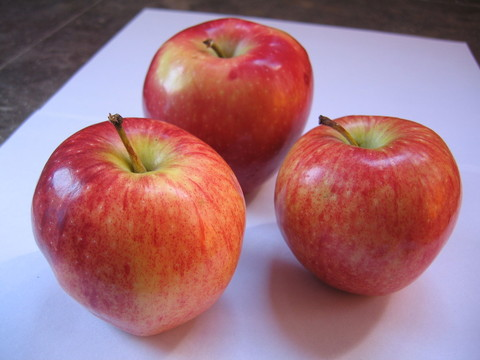

In [57]:
im = cv2.imread("/content/fruit_dataset/val/apple_31.jpg")
cv2_imshow(im)

In [58]:
cfg_pred = get_cfg()
add_deeplab_config(cfg_pred)
add_maskformer2_config(cfg_pred)
cfg_pred.merge_from_file("/content/Mask2Former/configs/coco/instance-segmentation/swin/maskformer2_swin_small_bs16_50ep.yaml")
cfg_pred.MODEL.WEIGHTS = "/content/Mask2Former/output/model_final.pth"
cfg_pred.MODEL.MASK_FORMER.TEST.SEMANTIC_ON = False
cfg_pred.MODEL.MASK_FORMER.TEST.INSTANCE_ON = True
cfg_pred.MODEL.MASK_FORMER.TEST.PANOPTIC_ON = False
cfg_pred.INPUT.IMAGE_SIZE = 700
cfg_pred.INPUT.FORMAT = 'RGB'
cfg_pred.TEST.DETECTIONS_PER_IMAGE = 2
cfg_pred.DATASETS.TRAIN = ("metadata_train",)
cfg_pred.DATASETS.TEST = ("metadata_val")
cfg_pred.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 4
predictor = DefaultPredictor(cfg_pred)

[12/28 14:43:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/Mask2Former/output/model_final.pth ...


criterion.empty_weight
sem_seg_head.predictor.class_embed.{bias, weight}


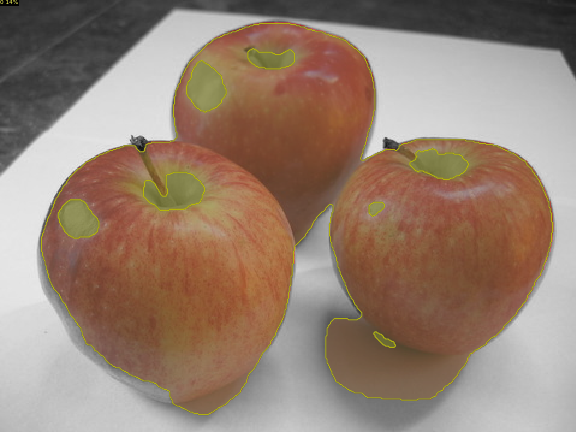

In [59]:
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], val_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
instance_result = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()
cv2_imshow(instance_result[:, :, ::-1])